### PDF를 전처리하고 벡터 DB 만들기

In [1]:
# 사용할 PDF 파일 확인하기
from glob import glob

for g in glob('../data/*.pdf'):
    print(g)

../data\2040_seoul_plan.pdf
../data\OneNYC_2050_Strategic_Plan.pdf


In [2]:
# PDF 파일을 텍스트로 읽고 청크 단위로 텍스트를 잘라 리스트로 담아 반환하는 함수
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

def read_pdf_and_split_text(pdf_path, chunk_size=1000, chunk_overlap=100):
    # 선택적 -> 사용자가 적지 않아도 자동으로 기본값을 사용합니다.
    """
    주어진 PDF 파일을 읽고 텍스트를 분할합니다.
    
    매개변수:
        pdf_path (str): PDF 파일의 경로.
        chunk_size (int, 선택적): 각 텍스트 청크의 크기. 기본값은 1000입니다.
        chunk_overlap (int, 선택적): 청크 간의 중첩 크기, 기본값은 100입니다.
    반환값:
        list: 분할된 텍스트 청크의 리스트
    """
    print(f"PDF: {pdf_path} -----------------------")

    pdf_loader = PyPDFLoader(pdf_path)
    data_from_pdf = pdf_loader.load()

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
    )

    splits = text_splitter.split_documents(data_from_pdf)

    print(f"Number of splits: {len(splits)}\n")
    return splits

In [3]:
# vectorstore 설정하고 청크 처리하기
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
import os

# vectorstore 설정
embedding = OpenAIEmbeddings(model='text-embedding-3-large')

persist_directory='../chroma_store'

if os.path.exists(persist_directory):
    print("Loading existing Chroma store")
    vectorstore = Chroma(
        persist_directory=persist_directory,
        embedding_function=embedding,
    )
else:
    print("Creating new Chroma store")

    vectorstore = None
    for g in glob('../data/*.pdf'): # glob는 파일 경로에서 특정 패턴을 가진 파일들을 한꺼번에 찾을 때 사용하는 모듈
        chunks = read_pdf_and_split_text(g) # 청크 크기는 1000, 오버랩은 100 기본값 사용
        # 청크를 100개씩 나눠서 저장
        for i in range(0, len(chunks), 100):
            if vectorstore is None:
                vectorstore = Chroma.from_documents(
                    documents=chunks[i:i + 100],
                    embedding=embedding,
                    persist_directory=persist_directory,
                )
            else:
                vectorstore.add_documents(
                    documents=chunks[i:i + 100]
                )


Loading existing Chroma store


In [4]:
# 벡터 DB 테스트
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

chunks = retriever.invoke("서울 온실가스 저감 계획")

for chunk in chunks:
    print(chunk.metadata)
    print(chunk.page_content)

{'creationdate': '2024-12-12T18:16:11+09:00', 'creator': 'Hwp 2020 11.0.0.5178', 'author': 'SI', 'total_pages': 205, 'source': '../data\\2040_seoul_plan.pdf', 'pdfversion': '1.4', 'moddate': '2024-12-12T18:16:11+09:00', 'page': 63, 'page_label': '64', 'producer': 'Hancom PDF 1.3.0.542'}
56제2장 미래상과 목표
6. 미래위기를 준비하는, ‘탄소중립 안전도시 구축’1) 배경전(全) 지구적인 기후변화에 대응하기 위한 대도시 차원의 대응 필요Ÿ서울시 2017년 온실가스 배출량은 46,685천 톤CO2eq로 2005년 배출량에 비해 5.6%(276만 톤CO2eq) 감소하였으며, 서울의 1인당 온실가스 배출량은 4.7CO2eq로 국가의 13.8톤CO2eq에 비해 낮은 수준이다. 또한 2014년 기준 서울의 1인당 온실가스 배출량은 4.5CO2eq로 세계 주요 도시에 비해 낮은 수준을 보인다.7)
[그림 2-26] 세계 주요 도시 1인당 온실가스 배출량   자료: World Bank, 2014Ÿ그럼에도 불구하고, 기후변화 문제는 21세기에 전 지구적으로 가장 위중한 영향을 미칠 것으로 예상되는바, 탄소중립과 기후위기 대응은 국제·국가·도시의 핵심 정책으로 다루어져야 한다.Ÿ파리협정(2015) 이후, 우리나라를 비롯한 미국, 유럽연합 등 세계 136개국이 탄소중립을 선언하였으며, 서울시를 비롯한 뉴욕, 런던 등과 같은 많은 글로벌 도시에서 탄소중립을 시정의 핵심과제로 추진 중이다.Ÿ우리나라는 2020년 ‘한국판 그린뉴딜’을 발표하며 공식적으로 2050 탄소중립을 선언하였으며 서울시 역시 2020년 ‘그린뉴딜 추진을 통한 2050 온실가스 감축 전략’을 발표하고 탄소중립 선언에 따른 부문별 사업을 적극 추진하고 있다.-서울시는 2050년 탄소중립을 목

In [5]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o-mini")
model.invoke("안녕하세요!")

AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 10, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BqyI1N4VMQx2pfgi20r2VBIJFoIYs', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--e2d4cf62-655c-4f46-8866-3313d5648eed-0', usage_metadata={'input_tokens': 10, 'output_tokens': 10, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

### 라우터
 - 일상적인 대화라면 casual_talk를 반환하고 RAG가 필요하면 vector_store를 반환합니다.

In [6]:
# 라우터 설정
from langchain_core.prompts import ChatPromptTemplate
from typing import Literal # 문자열 리터럴 타입을 지원하는 typing 모듈의 클래스
from pydantic import BaseModel, Field

# RouteQuery Data model
class RouteQuery(BaseModel):
    """사용자 쿼리를 가장 관련성이 높은 데이터 소스로 라우팅합니다."""

    datasource: Literal["vectorstore", "casual"] = Field( # vectorstore와 casual_talk 둘 중 하나의 값만 허용
        ..., # 이 필드는 반드시 값을 입력해야 한다 (required)
        description="""
        사용자 질문에 따라 casual 또는 vectorstore로 라우팅합니다.
        - casual: 일상 대화를 위한 데이터 소스. 사용자가 일상적인 질문을 할 때 사용합니다.
        - vectorstore: 사용자 질문에 답하기 위해 RAG로 vectorstore 검색이 필요한 경우 사용합니다.
        """,
    )

#### Literal 설정한 이유
```
description="""
        사용자 질문에 따라 'casual_talk' 또는 'vectorstore'로 값을 설정하세요.
        - casual_talk: 일상 대화를 위한 데이터 소스
        - vectorstore: RAG 검색이 필요한 경우
        """
```
이렇게 할 경우 "vectorstore입니다". 같은 불필요한 내용이 답변에 들어갈 수 있다. + 엉뚱한 str 생성 방지

In [7]:
# 사용자 질문 받고 판단하기
# 특정 모델을 structured output(구조화된 출력)과 함께 사용하기 위해 설정
# datasource='vectorstore'나 'casual_talk'만 출력
structured_llm_router = model.with_structured_output(RouteQuery)

router_system = """
당신은 사용자의 질문을 vectorstore 또는 casual으로 라우팅하는 전문가입니다.
- vectorstore에는 서울, 뉴욕의 발전계획과 관련된 문서가 포함되어 있습니다. 이 주제에 대한 질문에는 vectorstore를 사용하십시오.
- 사용자의 질문이 일상 대화에 관련된 경우 casual를 사용하십시오.
"""

# 시스템 메시지와 사용자의 질문을 포함하는 프롬프트 템플릿 생성
route_prompt = ChatPromptTemplate.from_messages([
    ("system", router_system),
    ("human", "{question}"),
])

# 라우터 프롬프트와 구조화된 출력 모델을 결합한 객체
question_route = route_prompt | structured_llm_router

In [8]:
# 구분 잘하는지 테스트
print(
    question_route.invoke({
        "question": "서울 온실가스 저감 계획은 무엇인가요?"
    })
)
print(
    question_route.invoke({
        "question": "잘 지냈어?"
    })
)

datasource='vectorstore'
datasource='casual'


### RAG 에이전트 만들기
 - 현재 리트리버는 무조건 청크를 5개 가져옴
 - 문서와 관련성을 판단하는 방법을 프롬프트로 작성하고 필요 없는 청크를 삭제해서 출력하도록 설정

In [9]:
# GradeDocuments 클래스
from langchain_core.prompts import PromptTemplate

class GradeDocuments(BaseModel):
    """검색된 문서가 질문과 관련성 있는지 yes 또는 no로 평가합니다."""

    binary_score: Literal["yes", "no"] = Field(
        description="문서가 질문과 관련이 있는지 여부를 'yes' 또는 'no로 평가합니다."
    )

structured_llm_grader = model.with_structured_output(GradeDocuments)

In [10]:
# 프롬프트 작성하고 테스트하기
# PromptTemplate 쓰는 이유 -> 기존 대화 내용이 계속 이어질 필요 없을 경우 더 적합 
grader_prompt = PromptTemplate.from_template("""
당신은 검색된 문서가 사용자 질문과 관련이 있는지 평가하는 평가자입니다. \n
문서에 사용자 질문과 관련된 키워드 또는 의미가 포함되어 있으면, 해당 문서를 관련성이 있다고 평가하십시오. \n
엄격한 테스트가 필요하지 않습니다. 목표는 잘못된 검색 결과를 걸러내는 것입니다. \n
문서가 질문과 관련이 있는지 여부를 나타내기 위해 'yes' 또는 'no'로 이진 점수를 부여하십시오.                                                                                                                                      
                                          
Retrievd document: \n {document} \n\n
User question: {question}
""")

retrieval_grader = grader_prompt | structured_llm_grader

# ------

question = "서울시 자율주행 관련 계획"
documents = retriever.invoke(question)

for doc in documents:
    print(doc)

page_content='54제2장 미래상과 목표
5. 기술발전에 선제적 대응, ‘미래교통 인프라 구축’1) 배경미래교통수단 도입에 따른 도시 활동 변화 및 공간구조 재편 대비Ÿ빠르게 진화하는 미래 신 교통수단은 도시공간에 새로운 변화를 일으킬 것이며, 도시 내 이동패턴의 변화를 가져올 것으로 예측된다. 이러한 점을 고려하여 도시 내 다양한 통행행태가 공존하는 포용적인 교통체계 구축을 준비해야 한다.미래교통수단 정착을 위한 도시 인프라 확충지원 필요Ÿ기존에 없던 새로운 교통은 통상 인프라 구축에 많은 시간이 소요되기 때문에 교통수단이 도입된 이후에 준비하기보다는 개발단계에서부터 이를 지원하기 위한 교통인프라 구축 구상이 요구되며, 새로운 도시 인프라 확충에 대한 도시계획적 지원이 필요하다.2) 추진전략자율주행 자동차 본격 운영 체계 구축Ÿ자율주행은 현재 제일 가시화되고 있는 미래 교통기술로 시장의 주도권을 확보하기 위해 각국의 노력이 집중되고 있다. 단계적으로 2030년까지 간선도로급 이상 도로에서 운영할 수 있는 도로 인프라 환경을 조성하고, 2040년까지 서울 전역 자율주행 운행 환경 구축을 목표로 한다.-2040년까지 서울 전역 자율주행차량의 운행 환경을 구축하고 수송 분담률 10%를 달성서울형 도심 항공교통 기반 마련 및 터미널 확충Ÿ도심에서 김포공항까지 시범노선을 운영하는 등 상용화 노선을 확보하고, 장기적으로 한강, 지천 등 주요 수변 공간 중심으로 광역노선을 확보한다. 또한 UAM 인프라 확보를 위한 인센티브 및 도시계획적인 지원 방안도 함께 검토한다.-UAM 시범노선을 운영하고, 한강 등 주요 수변 공간 중심에 단계적 광역노선을 확장서울 전역에 모빌리티 허브 구축Ÿ도심 및 광역거점에 서울 내부와 외부의 연계를 위한 미래 교통과 기존 교통을 연결하는 시설을 도입한다. 또한 교통뿐 아니라 공공서비스, 물류, 상업 등 다양한 기능들이 복합적으로 제공되는 지역 거점 모빌리티 허브를 서울 전역에 도입한다.' metadata={'creationdate': 

In [11]:
# 관련된 청크만 리스트에 추가
filtered_docs = []

# index 필요할 경우 enumerate 사용
for i, doc in enumerate(documents):
    print(f"Document {i + 1}:")
    is_relevant = retrieval_grader.invoke({"question": question, "document": doc.page_content})
    print(is_relevant)
    print(doc.page_content[:200])
    print("=================================\n\n")

    if is_relevant.binary_score == "yes":
        filtered_docs.append(doc)

print(f"Filtered documents: {len(filtered_docs)}")

Document 1:
binary_score='yes'
54제2장 미래상과 목표
5. 기술발전에 선제적 대응, ‘미래교통 인프라 구축’1) 배경미래교통수단 도입에 따른 도시 활동 변화 및 공간구조 재편 대비Ÿ빠르게 진화하는 미래 신 교통수단은 도시공간에 새로운 변화를 일으킬 것이며, 도시 내 이동패턴의 변화를 가져올 것으로 예측된다. 이러한 점을 고려하여 도시 내 다양한 통행행태가 공존하는 포용적인 교통체계 구


Document 2:
binary_score='yes'
36제2장 미래상과 목표
6) 미래교통수단의 등장과 첨단 인프라 요구 증대자율주행, UAM 등 미래 교통에 공간적 대응방안 마련 필요Ÿ자율주행차량, 전동킥보드 등 교통 기술의 발전에 따라 새로운 교통환경이 조성되고 있음에도 불구하고, 이에 대한 정착 가이드라인이 없어, 위험한 교통 사고가 유발되고 있다.-최근 3년간 서울시에서 발생한 전동킥보드 관련 사고 


Document 3:
binary_score='no'
제1절 도시공간구조105기능이 공존하는 미래 도심으로 조성-국제 디지털 금융중심지인 여의도·영등포는 한강을 중심으로 한 글로벌 혁신코어 조성-국제 업무 중심지인 강남은 영동대로와 경부간선도로의 입체복합화로 가용지를 확보하여 업무복합기능을 강화 Ÿ수도 서울의 위상 강화를 위해 “광화문~용산~영등포”축을 국가중심공간으로 조성한다.-북악산~청와대~광화문광장~서울


Document 4:
binary_score='yes'
광화문·시청역을, GTX-B 노선은 종로3가역 또는 동대문역 신설 제안을 검토Ÿ자전거를 비롯하여 개인용 이동수단(PM), 수상교통, 도심항공교통(UAM) 등 신 이동수단으로 도심 간 연결 수단을 다양화하고, 교통수단 상용화에 필요한 인프라를 구축한다.-여의도~잠실종합운동장, 남산공원~용산공원~용산역(정비창)~여의도 등을 연결하는 신 이동수단의 인프라 신설을


Document 5:
binary_score='no'
제3절 권역별 구상147보행 중심 교통체계 전환을 위한 친환경 

In [12]:
# RAG를 위한 프롬프트 생성하기
rag_generate_system = """
너는 사용자의 질문에 대해 주어진 context에 기반하여 답변하는 도시 계획 전문가이다.
주어진 context는 vectorstore에서 검색된 결과이다.
주어진 context를 기반으로 사용자의 question에 대해 답변하라.

=================================
question: {question}
context: {context}
"""

# PromptTemplate를 생성해 question과 context를 포매팅
rag_prompt = PromptTemplate(
    input_variables=["question", "context"],
    template=rag_generate_system,
)

# 체인 형성
rag_chain = rag_prompt | model

# 사용자 질문과 검색된 문서를 입력으로 사용해 RAG를 실행
question = "서울시 자율주행 관련 계획"

rag_chain.invoke({"question": question, "context": filtered_docs})

AIMessage(content='서울시는 자율주행 관련 계획을 통해 2030년까지 간선도로급 이상 도로에서 자율주행 자동차 운영을 위한 도로 인프라 환경을 조성하고, 2040년까지는 서울 전역에 자율주행 차량의 운행 환경을 구축할 목표를 세웠습니다. 이 계획의 일환으로, 자율주행차량의 수송 분담률을 10% 달성하는 것을 목표로 하고 있습니다.\n\n또한, 서울시는 도심 항공교통(UAM) 기반 마련과 터미널 확충도 추진하고 있으며, 도심에서 김포공항까지의 시범노선을 운영하여 장기적으로는 주요 수변 공간 중심으로 광역노선을 확보할 계획입니다. 이를 위해 다양한 모빌리티 허브를 서울 전역에 구축하여 공공서비스, 물류, 상업 등 여러 기능이 복합적으로 제공되는 지역 거점으로 발전시키려 하고 있습니다.\n\n이러한 자율주행 및 미래교통수단의 도입은 서울시 도시 공간과 이동 패턴에 중대한 변화를 가져올 것으로 예상되며, 이에 따라 통합적인 교통수단 정착 가이드라인이 필요하다고 강조하고 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 265, 'prompt_tokens': 1790, 'total_tokens': 2055, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BqyI75RC0iq4gTiFfxQ94YzgSieY2', 'service_tier': 'de

### RAG 에이전트에 필요한 기능(노드)를 다 만들었으니 이 기능들을 엮어서 하나의 그래프로 만들기

In [13]:
# 그래프 상태 선언
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    question: str # 사용자 질문
    generation: str # LLM 생성 결과
    documents: List[str] # 불필요한 청크 거른 청크 모음

In [14]:
# 사용자 질문을 vectorstore 또는 casual_talk로 라우팅하는 함수
def route_question(state):
    """
    사용자 질문을 용자 질문을 vectorstore 또는 casual_talk로 라우팅합니다.

    Args:
        state (dict): 현재 graph state

    return:
        state (dict): 라우팅된 데이터 소스와 사용자 질문을 포함하는 새로운 graph state
    """
    print('-----ROUTE-----')
    question = state['question']
    # 앞에서 정의한 라우터 프롬프트와 구조화된 출력 모델(vectorstore와 casual_talk만 반환하는)을 결합한 객체
    route = question_route.invoke({"question": question})

    print(f"---Routing to {route.datasource}---")
    return route.datasource

In [15]:
# retrieve 노드 정의
def retrieve(state):
    """
    vectorstore에서 질문에 대한 문서를 검색합니다.

    Args:
        state (dict): 현재 graph state

    return:
        state (dict): 검색된 문서와 사용자 질문을 포함하는 새로운 graph sate
    """
    print('-----RETRIEVE-----')
    question = state['question']

    # Retrieve documents
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [16]:
# grade_documents 노드 정의 - 필요한 청크만 가져오고 state의 documents를 필터된 청크들로 업데이트
def grade_documents(state):
    """
    검색된 문서를 평가하여 질문과 관련성이 있는지 확인합니다.

    Args:
        state (dict): 현재 graph state

    return:
        state (dict): 관련성이 있는 문서와 사용자 질문을 포함하는 새로운 graph state
    """
    print('-----GRADE-----')
    question = state['question']
    documents = state['documents']
    filtered_docs = []

    for i, doc in enumerate(documents):
        is_relevant = retrieval_grader.invoke({"question": question, "document": doc.page_content})
        if is_relevant.binary_score == "yes":
            filtered_docs.append(doc)

    return {"documents": filtered_docs, "question": question}

In [17]:
# genertate 노드 정의
def generate(state):
    """
    LLM을 사용하여 문서와 사용자 질문에 대한 답변을 생성합니다.

    Args:
        state (dict): 현재 graph state

    return
        state (dict): LLM 생성 결과와 사용자 질문을 포함하는 새로운 graph state
    """
    print('-----GENERATE')
    question = state['question']
    documents = state['documents']
    generation = rag_chain.invoke({"question": question, "context": documents})
    return{
        "documents": documents,
        "question": question,
        "generation": generation
    }

In [18]:
# casual_talk 노드
def casual_talk(state):
    """
    일상 대화를 위한 답변을 생성합니다.

    Args:
        state (dict): 현재 graph state
    
    return:
        state (dict): 일상 대화 결과와 사용자 질문을 포함하는 새로운 graph state
    """
    print('-----CASUAL TALK-----')
    question = state['question']
    generation = model.invoke(question)
    return {
        "question": question,
        "generation": generation
    }

### StateGraph 만들기
 - 랭그래프를 사용하려면 StateGraph를 만들고 노드들을 등록한 후, 각 노드들의 연결 관계를 정의해야 합니다.

In [19]:
# StateGraph 객체 생성
from langgraph.graph import START, StateGraph, END
workflow = StateGraph(GraphState)  

In [20]:
# 먼저 만든 함수들을 노드로 등록하고 연결
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("casual_talk", casual_talk)

In [21]:
# 그래프 정의하기 - .add_edge로 연결
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "vectorstore": "retrieve",
        "casual": "casual_talk",
    }
)

workflow.add_edge("casual_talk", END)
workflow.add_edge("retrieve", "grade_documents")
workflow.add_edge("grade_documents", "generate")
workflow.add_edge("generate", END)

# workflow를 실행 가능한 app으로 컴파일
app = workflow.compile() 

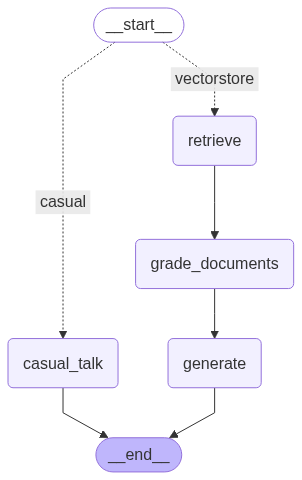

In [22]:
# 그래프 출력하기
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # 실패 시 통과
    pass

In [24]:
# 멀티에이전트 테스트
inputs = {
    "question": "서울시 자율주행 계획"
}

app.invoke(inputs) # workflow 실행

-----ROUTE-----
---Routing to vectorstore---
-----RETRIEVE-----
-----GRADE-----
-----GENERATE


{'question': '서울시 자율주행 계획',
 'generation': AIMessage(content='서울시는 자율주행 교통 수단의 본격 운영 체계를 구축하는 데 중점을 두고 있으며, 2030년까지 간선도로급 이상의 도로에서 자율주행차량을 운영할 수 있는 인프라 환경을 조성할 계획입니다. 2040년까지는 서울 전역에서 자율주행차의 운행 환경을 구축하고, 수송 분담률을 10% 달성하는 것을 목표로 하고 있습니다.\n\n이에 따라 서울시는 새로운 도시 인프라의 확충을 필요로 하며, 자율주행차뿐만 아니라 도심 항공교통(UAM) 및 다양한 모빌리티 허브의 구축도 추진하고 있습니다. 이를 통해 도시 내의 기존 교통과 미래의 교통을 통합하여 포괄적인 교통 체계를 조성하겠다는 목표를 가지고 있습니다.\n\n자율주행차량의 도입과 관련된 인프라 구축은 개발 단계에서부터 준비해야 하며, 안전하고 효율적인 교통 수단의 조화를 위한 가이드라인 마련이 필요하다고 언급되고 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 238, 'prompt_tokens': 1789, 'total_tokens': 2027, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BqyKYg2ebveOxByA7D5IQyG4OToET', 'service_tier': 'default', 'fi

In [25]:
# 워크플로 확인하기
inputs = {
    "question": "잘 지내?"
}

app.invoke(inputs) # workflow 실행

-----ROUTE-----
---Routing to casual---
-----CASUAL TALK-----


{'question': '잘 지내?',
 'generation': AIMessage(content='저는 잘 지내고 있습니다! 당신은 어떻게 지내고 계신가요? 도움이 필요하시면 언제든지 말씀해 주세요.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 11, 'total_tokens': 41, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BqyL6KsKh3ANyCB6aIbmfO0URNoOV', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--1c87d6ed-b6aa-4e24-8207-516732a09611-0', usage_metadata={'input_tokens': 11, 'output_tokens': 30, 'total_tokens': 41, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}

In [27]:
# 스트림 방식으로 출력하기
inputs = {
    "question": "서울시의 자율주행 차량 계획은 무엇이 있나요?"
}

for msg, meta in app.stream(inputs, stream_mode="messages"):
    print(msg.content, end='')

-----ROUTE-----
{"datasource":"vectorstore"}---Routing to vectorstore---
-----RETRIEVE-----
-----GRADE-----
{"binary_score":"yes"}{"binary_score":"yes"}{"binary_score":"no"}{"binary_score":"no"}{"binary_score":"yes"}-----GENERATE
서울시의 자율주행 차량 계획은 크게 두 가지로 나눌 수 있습니다. 

첫째, **자율주행 자동차 운영 체계 구축**입니다. 서울시는 2030년까지 간선도로급 이상의 도로에서 자율주행 차량이 운영될 수 있는 인프라 환경을 조성하고, 2040년까지 서울 전역에서 자율주행 차량의 운행 환경을 구축하는 것을 목표로 하고 있습니다. 이 계획의 일환으로 2040년까지 자율주행 차량의 수송 분담률을 10%까지 달성하려고 하고 있습니다.

둘째, **모빌리티 허브 및 도심 항공교통(UAM) 기반 마련**입니다. 서울시는 도심에서 김포공항까지의 시범노선을 운영하며, 장기적으로 한강 등 주요 수변 공간을 중심으로 광역노선을 확충할 계획입니다. 이러한 움직임은 자율주행 차량의 정착과 함께 다양한 교통수단을 통합하는 모빌리티 허브의 구축을 포함합니다.

이와 같은 계획들은 서울시의 교통 혼잡을 완화하고, 안전하고 효율적인 교통 환경을 조성하기 위한 중요한 기초를 마련하고 있습니다.